In [12]:

import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import  plotly
from wordcloud import WordCloud,STOPWORDS
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mahmoud/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:

# Importing the dataset
tweets_df = pd.read_csv('Tweets.csv')
tweets_df = tweets_df[['text', 'airline_sentiment']]
tweets_df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
tweets_df.shape

(14640, 2)

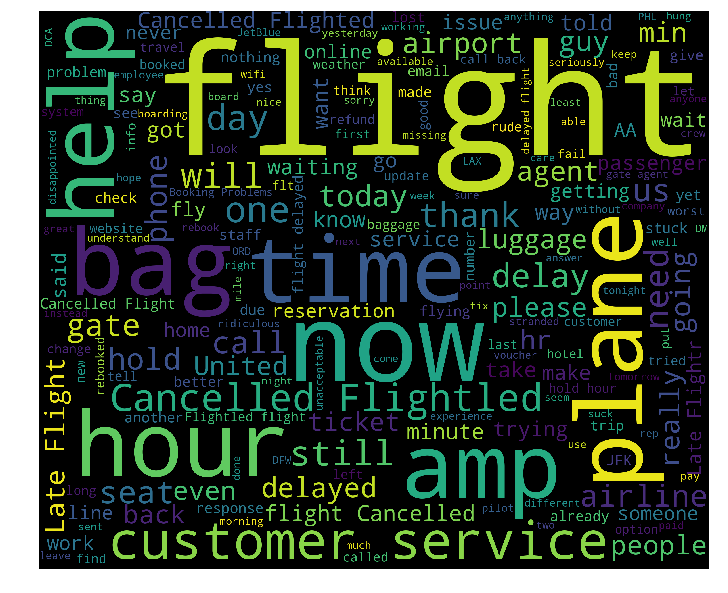

In [6]:

df_negative = tweets_df[tweets_df['airline_sentiment']=='negative']
words = ' '.join(df_negative['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


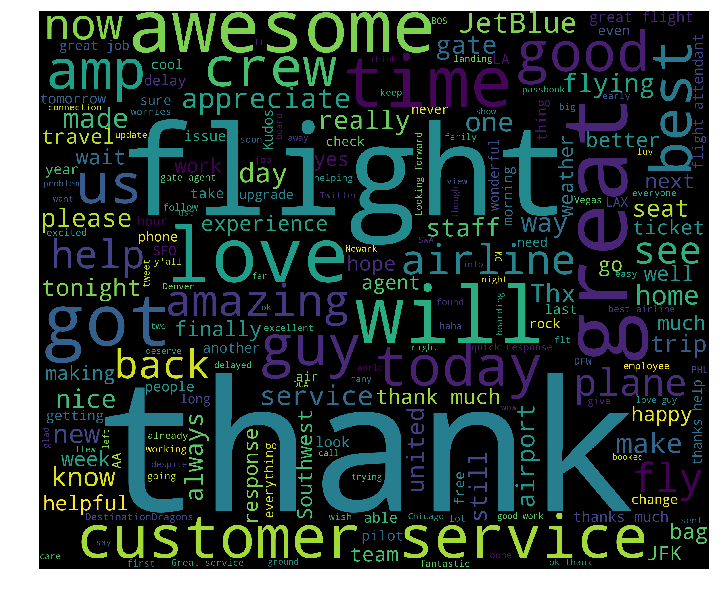

In [7]:
#visualization using wordcloud for the positive tweets
df_postive = tweets_df [tweets_df['airline_sentiment']=='positive']
words = ' '.join(df_postive['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


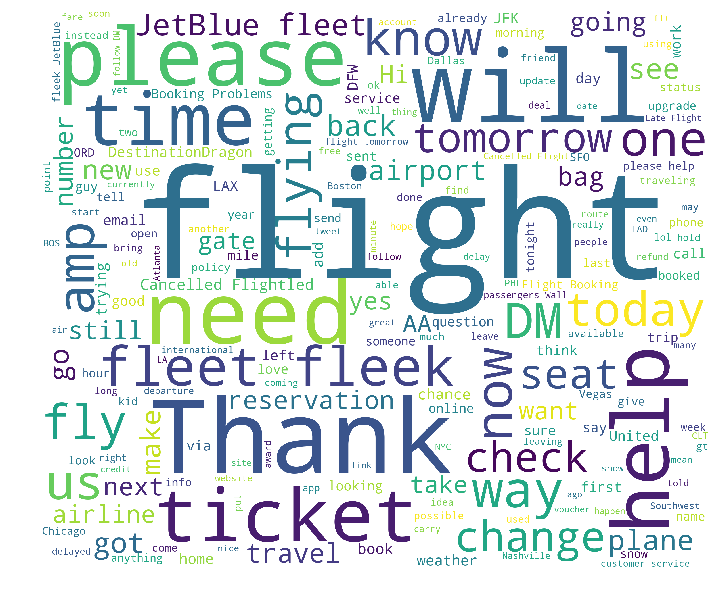

In [8]:

#visualization using wordcloud for the neutral tweets
df_neutral = tweets_df[tweets_df['airline_sentiment']=='neutral']
words = ' '.join(df_neutral['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Machine Learning

In [10]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


In [13]:

tweets_df.text = tweets_df.text.apply(remove_stopwords).apply(remove_mentions)

X_train, X_test, y_train, y_test = train_test_split(tweets_df.text, tweets_df.airline_sentiment, test_size=0.1, random_state=37)


In [16]:

tk = Tokenizer(num_words= 10000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

def one_hot_seq(seqs, nb_features = 10000):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]


In [17]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, init = 'uniform', activation='relu', input_shape=(10000,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64,init = 'uniform', activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
#drop_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(drop_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________
None


/home/mahmoud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", input_shape=(10000,), kernel_initializer="uniform")`

/home/mahmoud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`



In [19]:

drop_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
drop_model.fit(X_train_rest,y_train_rest, batch_size = 64, nb_epoch = 10)

/home/mahmoud/.local/lib/python3.6/site-packages/keras/models.py:981: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/10
11858/11858 [==============================] - 3s 261us/step - loss: 0.1450 - acc: 0.9470
Epoch 2/10
11858/11858 [==============================] - 3s 240us/step - loss: 0.1247 - acc: 0.9552
Epoch 3/10
11858/11858 [==============================] - 3s 231us/step - loss: 0.1024 - acc: 0.9632
Epoch 4/10
11858/11858 [==============================] - 3s 231us/step - loss: 0.0929 - acc: 0.9670
Epoch 5/10
11858/11858 [==============================] - 3s 232us/step - loss: 0.0770 - acc: 0.9720
Epoch 6/10
11858/11858 [==============================] - 3s 232us/step - loss: 0.0671 - acc: 0.9759
Epoch 7/10
11858/11858 [==============================] - 3s 231us/step - loss: 0.0597 - acc: 0.9784
Epoch 8/10
11858/11858 [==============================] - 3s 234us/step - loss: 0.0551 - acc: 0.9826
Epoch 9/10
11858/11858 [==============================] - 3s 230us/step - loss: 0.0484 - acc: 0.9843
Epoch 10/10
11858/11858 [==============================] - 3s 234us/step - loss: 0.0427 - a